# Appendix 10.4.5: Using Haiku as a sub-agent

In this recipe, we'll demonstrate how to analyze Apple's 2023 financial earnings reports using Claude 3.5 Haiku sub-agent models to extract relevant information from earnings release PDFs. We'll then use Claude 3.5 Sonnet v2 to generate a response to our question and create a graph using matplotlib to accompany its response.

## Step 1: Set up the environment
First, let's install the required libraries and set up the Anthropic API client.

In [ ]:
pip install -qUr requirements.txt

In [2]:
# Import the required libraries
import boto3
import fitz
from PIL import Image
import io
from concurrent.futures import ThreadPoolExecutor
import requests
import os
import seaborn as sns

session = boto3.Session()
region = session.region_name

modelId = 'anthropic.claude-3-5-sonnet-20241022-v2:0'

print(f'Using modelId: {modelId}')
print('Using region: ', region)

bedrock_client = boto3.client(service_name = 'bedrock-runtime', region_name = region,)

Matplotlib is building the font cache; this may take a moment.


Using modelId: anthropic.claude-3-5-sonnet-20241022-v2:0
Using region:  us-west-2


In [5]:
# List of Apple's earnings release PDF URLs
pdf_urls = [
    "https://www.apple.com/newsroom/pdfs/fy2023-q4/FY23_Q4_Consolidated_Financial_Statements.pdf",
    "https://www.apple.com/newsroom/pdfs/fy2023-q3/FY23_Q3_Consolidated_Financial_Statements.pdf",
    "https://www.apple.com/newsroom/pdfs/FY23_Q2_Consolidated_Financial_Statements.pdf",
    "https://www.apple.com/newsroom/pdfs/FY23_Q1_Consolidated_Financial_Statements.pdf"
]

# User's question
QUESTION = "How did Apple's net sales change quarter to quarter in the 2023 financial year and what were the key contributors to the changes?"

In [6]:
def call_claude(prompt, image_data=None):
    converse_api_params = {
        "modelId": "anthropic.claude-3-5-sonnet-20241022-v2:0",
        "messages": [{
            "role": "user",
            "content": []
        }],
        "inferenceConfig": {
            "maxTokens": 4096
        },
    }

    if image_data:
        converse_api_params["messages"][0]["content"].append({
            "image": {
                "format": "pdf",
                "source": {"bytes": image_data}
            }
        })

    converse_api_params["messages"][0]["content"].append({"text": prompt})

    response = bedrock_client.converse(**converse_api_params)
    return response['output']['message']['content'][0]['text']

def call_primary_claude(prompt, sub_agent_outputs):
    converse_api_params = {
        "modelId": modelId,
        "messages": [{
            "role": "user",
            "content": [{"text": prompt + "\n\n" + sub_agent_outputs}]
        }],
        "inferenceConfig": {
            "maxTokens": 4096
        },
    }

    response = bedrock_client.converse(**converse_api_params)
    return response['output']['message']['content'][0]['text']

In [7]:
# Function to download a PDF file from a URL and save it to a specified folder
def download_pdf(url, folder):
    response = requests.get(url)
    if response.status_code == 200:
        file_name = os.path.join(folder, url.split("/")[-1])
        with open(file_name, "wb") as file:
            file.write(response.content)
        return file_name
    else:
        print(f"Failed to download PDF from {url}")
        return None
    
# Define the function to convert a PDF to a list of base64-encoded PNG images
def pdf_to_png(pdf_path, quality=75, max_size=(1024, 1024)):
    # Open the PDF file
    doc = fitz.open(pdf_path)
    pdf_to_png_images = []

    # Iterate through each page of the PDF
    for page_num in range(doc.page_count):
        # Load the page
        page = doc.load_page(page_num)

        # Render the page as a PNG image
        pix = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72))

        # Convert the pixmap to a PIL Image
        image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

        # Resize the image if it exceeds the maximum size
        if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
            image.thumbnail(max_size, Image.Resampling.LANCZOS)

        # Convert the PIL image to bytes
        image_data = io.BytesIO()
        image.save(image_data, format='PNG', optimize=True, quality=quality)
        image_data.seek(0)
        pdf_to_png_image = image_data.getvalue()

        # Append the PNG image bytes to the list
        pdf_to_png_images.append(pdf_to_png_image)

    # Close the PDF document
    doc.close()

    return pdf_to_png_images

# Folder to save the downloaded PDFs
folder = "./images/using_sub_agents"

# Download the PDFs concurrently
with ThreadPoolExecutor() as executor:
    pdf_paths = list(executor.map(download_pdf, pdf_urls, [folder] * len(pdf_urls)))

# Remove any None values (failed downloads) from pdf_paths
pdf_paths = [path for path in pdf_paths if path is not None]

We use ThreadPoolExecutor to download the PDFs concurrently and store the file paths in pdf_paths.

## Step 4: Generate a specific prompt for Haiku using Sonnet
Let's use Claude 3.5 Sonnet v2 as an orchestrator and have it write a specific prompt for each Haiku sub-agent based on the user provided question.

In [8]:
def generate_haiku_prompt(question):
    prompt = f"""Based on the following question, please generate a specific prompt for an LLM sub-agent to extract relevant information from an earning's report PDF. Each sub-agent only has access to a single quarter's earnings report. Output only the prompt and nothing else.\n\nQuestion: {question}"""
    messages = [
        {
            "role": 'user',
            "content": [
                {"text": prompt }
            ]
        }
    ]

    converse_api_params = {
        "modelId": modelId,
        "messages": messages,
    }

    response = bedrock_client.converse(**converse_api_params)

    return response['output']['message']['content'][0]['text']

haiku_prompt = generate_haiku_prompt(QUESTION)
print(haiku_prompt)

Please analyze this earnings report and extract the following information:

1. The total net sales figure for this quarter
2. The year-over-year change in net sales (both percentage and absolute value)
3. Net sales figures broken down by:
   - Product categories (iPhone, Mac, iPad, Wearables/Home/Accessories, Services)
   - Geographic segments

4. Key factors mentioned that contributed to sales performance, specifically:
   - Product launches or updates
   - Market conditions
   - Supply chain impacts
   - Pricing changes
   - Currency effects
   - Any other significant factors cited by management

5. Any forward-looking statements or guidance about sales trends

Present the data in a structured format and include direct quotes from the report where relevant to explaining sales changes. Ensure all monetary values are in billions of USD and specify if any figures are rounded.


## Step 5: Extract information from PDFs
Now, let's define our question and extract information from the PDFs using sub-agent Haiku models. We format the information from each model into a neatly defined set of XML tags.

In [10]:
def extract_info(pdf_path, haiku_prompt):
    pdf_pngs = pdf_to_png(pdf_path)

    messages = [
        {
            "role": "user",
            "content": [
                *[{"image": {"format": 'png', "source": {"bytes": pdf_png}}} for pdf_png in pdf_pngs],
                {"text": haiku_prompt}
            ]
        }
    ]

    converse_api_params = {
        "modelId": "anthropic.claude-3-haiku-20240307-v1:0",
        "messages": messages,
    }
    response = bedrock_client.converse(**converse_api_params)

    return response['output']['message']['content'][0]['text'], pdf_path

def process_pdf(pdf_path):
    return extract_info(pdf_path, QUESTION)

# Process the PDFs concurrently with Haiku sub-agent models
with ThreadPoolExecutor() as executor:
    extracted_info_list = list(executor.map(process_pdf, pdf_paths))

extracted_info = ""
# Display the extracted information from each model call
for info in extracted_info_list:
    extracted_info += "<info quarter=\"" + info[1].split("/")[-1].split("_")[1] + "\">" + info[0] + "</info>\n"
print(extracted_info)

<info quarter="Q4">Based on the condensed consolidated statements of operations, Apple's net sales changed as follows from the three months ended September 30, 2022 to the three months ended September 30, 2023:

- Total net sales increased from $90,146 million to $89,498 million, a decrease of $648 million.

The key contributors to the change in net sales were:

- Product sales decreased from $70,958 million to $67,184 million, a decrease of $3,774 million. This was primarily driven by lower iPhone sales.
- Services sales increased from $19,188 million to $22,314 million, an increase of $3,126 million. This was due to growth in the Services category.

So in summary, the decrease in total net sales was primarily attributable to lower product sales, particularly iPhone, which was partially offset by growth in the higher-margin Services segment.</info>
<info quarter="Q3">Based on the "CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (Unaudited)" for Apple Inc., we can see the following cha

We extract information from the PDFs concurrently using sub-agent models and combine the extracted information. We then prepare the messages for the powerful model, including the question and the extracted information, and ask it to generate a response and matplotlib code.

## Step 6: Pass the information to Sonnet to generate a response
Now that we have fetched the information from each PDF using the sub-agents, let's call Claude 3.5 Sonnet v2 to actually answer the question and write code to create a graph to accompany the answer.

In [11]:
# Prepare the messages for the powerful model
messages = [
    {
        "role": "user",
        "content": [
            {"text": f"Based on the following extracted information from Apple's earnings releases, please provide a response to the question: {QUESTION}\n\nAlso, please generate Python code using the matplotlib library to accompany your response. Enclose the code within <code> tags.\n\nExtracted Information:\n{extracted_info}"}
        ]
    }
]

# Generate the matplotlib code using the powerful model
converse_api_params = {
    "modelId": "anthropic.claude-3-5-sonnet-20241022-v2:0",
    "messages": messages,
    "inferenceConfig": {"maxTokens": 4096},
}
response = bedrock_client.converse(**converse_api_params)

generated_response = response['output']['message']['content'][0]['text']
print("Generated Response:")
print(generated_response)

Generated Response:
Based on the provided information, here's how Apple's net sales changed quarter to quarter in FY2023:

Q1 2023: $117,154 million (↓5.5% YoY)
Q2 2023: $94,836 million 
Q3 2023: $81,797 million (↓1.4% YoY)
Q4 2023: $89,498 million (↓0.7% YoY)

Key trends:
1. Throughout FY2023, Product sales consistently decreased year-over-year
2. Services revenue showed consistent growth throughout the year
3. The largest decline was in Q1 2023 (↓5.5%)
4. Services revenue helped offset some of the Product revenue decline

Here's the Python code to visualize this data:

<code>
import matplotlib.pyplot as plt
import numpy as np

# Data
quarters = ['Q1 2023', 'Q2 2023', 'Q3 2023', 'Q4 2023']
total_sales = [117154, 94836, 81797, 89498]
product_sales = [96388, 46795, 60584, 67184]
services_sales = [20766, 20907, 21213, 22314]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the stacked bar chart
ax.bar(quarters, product_sales, label='Products', color='#2E86C1')


## Step 7: Extract response and execute Matplotlib code
Finally, let's extract the matplotlib code from the generated response and execute it to visualize the revenue growth trend.

We define the ```extract_code_and_response``` function to extract the matplotlib code and non-code response from the generated response. We print the non-code response and execute the matplotlib code if it is found.

Note that it is not good practice to use ```exec``` on model-written code outside of a sandbox but for the purposes of this demo we are doing it :)

Based on the provided information, here's how Apple's net sales changed quarter to quarter in FY2023:

Q1 2023: $117,154 million (↓5.5% YoY)
Q2 2023: $94,836 million 
Q3 2023: $81,797 million (↓1.4% YoY)
Q4 2023: $89,498 million (↓0.7% YoY)

Key trends:
1. Throughout FY2023, Product sales consistently decreased year-over-year
2. Services revenue showed consistent growth throughout the year
3. The largest decline was in Q1 2023 (↓5.5%)
4. Services revenue helped offset some of the Product revenue decline

Here's the Python code to visualize this data:


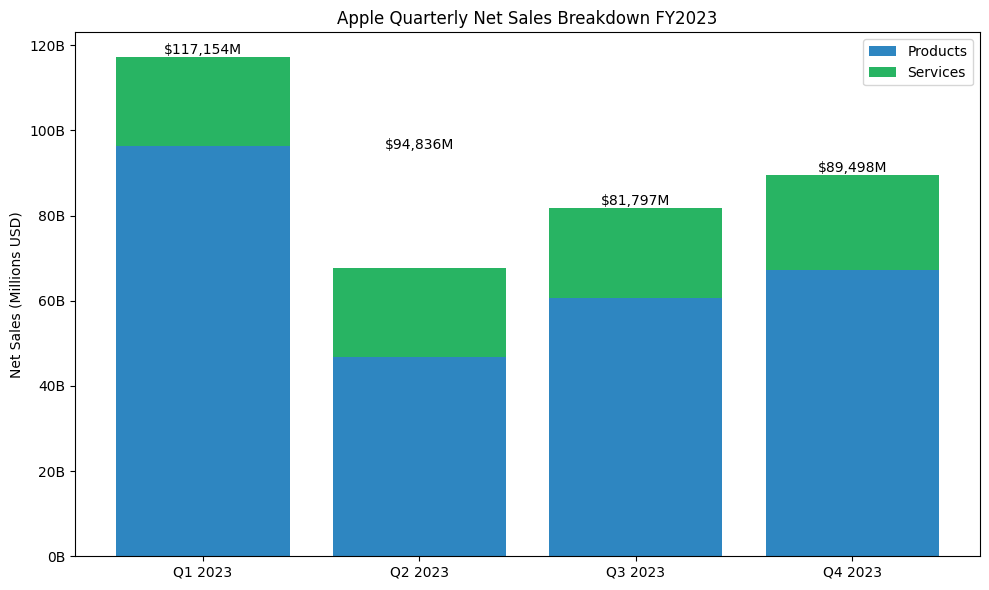

In [12]:
# Extract the matplotlib code from the response
# Function to extract the code and non-code parts from the response
def extract_code_and_response(response):
    start_tag = "<code>"
    end_tag = "</code>"
    start_index = response.find(start_tag)
    end_index = response.find(end_tag)
    if start_index != -1 and end_index != -1:
        code = response[start_index + len(start_tag):end_index].strip()
        non_code_response = response[:start_index].strip()
        return code, non_code_response
    else:
        return None, response.strip()

matplotlib_code, non_code_response = extract_code_and_response(generated_response)
print(non_code_response)

if matplotlib_code:
    # Modify the extracted code if it contains plt.style.use('seaborn')
    if "plt.style.use('seaborn')" in matplotlib_code or 'plt.style.use("seaborn")' in matplotlib_code:
        matplotlib_code = matplotlib_code.replace("plt.style.use('seaborn')", "import seaborn as sns\nsns.set_theme()")
        matplotlib_code = matplotlib_code.replace('plt.style.use("seaborn")', "import seaborn as sns\nsns.set_theme()")
    
    # Execute the extracted matplotlib code
    exec(matplotlib_code)
else:
    print("No matplotlib code found in the response.")